# BWT-DE Project 1

## Logging Function

In [129]:
import logging

# Remove all handlers associated with the root logger object
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Set up logging
logging.basicConfig(filename='./bank_data.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def log_message(message):
    logging.info(message)


## Data Extraction

In [130]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

def scrape_data(url):
    log_message('Starting data extraction from Wikipedia')
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find all tables with the class 'wikitable'
    tables = soup.find_all('table', {'class': 'wikitable'})

    # Check if we have enough tables
    if len(tables) < 2:
        log_message('Not enough tables found.')
        return None, None

    # Extract data from the first table
    headers1 = [header.text.strip() for header in tables[0].find_all('th')]
    rows1 = []
    for row in tables[0].find_all('tr')[1:]:
        rows1.append([cell.text.strip() for cell in row.find_all(['td', 'th'])])
    df1 = pd.DataFrame(rows1, columns=headers1)

    # Extract data from the second table
    headers2 = [header.text.strip() for header in tables[1].find_all('th')]
    rows2 = []
    for row in tables[1].find_all('tr')[1:]:
        rows2.append([cell.text.strip() for cell in row.find_all(['td', 'th'])])
    df2 = pd.DataFrame(rows2, columns=headers2)

    log_message('Data extraction completed')
    return df1, df2

url = 'https://web.archive.org/web/20230908091635/https://en.wikipedia.org/wiki/List_of_largest_banks'
df1, df2 = scrape_data(url)

# Print the first few rows of each DataFrame
print(df1.head())
print(df2.head())


  Rank                                Bank name Market cap(US$ billion)
0    1                           JPMorgan Chase                  432.92
1    2                          Bank of America                  231.52
2    3  Industrial and Commercial Bank of China                  194.56
3    4               Agricultural Bank of China                  160.68
4    5                                HDFC Bank                  157.91
  Rank                                        Bank name  \
0    1  Industrial and Commercial Bank of China Limited   
1    2                          China Construction Bank   
2    3                       Agricultural Bank of China   
3    4                                    Bank of China   
4    5                                   JPMorgan Chase   

  Total assets(2022)(US$ billion)  
0                        5,742.86  
1                        5,016.81  
2                        4,919.03  
3                        4,192.12  
4                        3,868.24

## Data Transformation

### Merge df1 and df2 to create banks_df

In [131]:
log_message('Starting data transformation')

# Merge df1 and df2 based on 'Bank name'
banks_df = pd.merge(df1, df2[['Bank name', 'Total assets(2022)(US$ billion)']],
                     left_on='Bank name',
                     right_on='Bank name',
                     how='left')

print(banks_df)

  Rank                                Bank name Market cap(US$ billion)  \
0    1                           JPMorgan Chase                  432.92   
1    2                          Bank of America                  231.52   
2    3  Industrial and Commercial Bank of China                  194.56   
3    4               Agricultural Bank of China                  160.68   
4    5                                HDFC Bank                  157.91   
5    6                              Wells Fargo                  155.87   
6    7                        HSBC Holdings PLC                  148.90   
7    8                           Morgan Stanley                  140.83   
8    9                  China Construction Bank                  139.82   
9   10                            Bank of China                  136.81   

  Total assets(2022)(US$ billion)  
0                        3,868.24  
1                        3,051.38  
2                             NaN  
3                        4,919

### Remove null values

In [132]:
# Remove null values
banks_df.dropna(inplace=True)
banks_df

,Rank,Bank name,Market cap(US$ billion),Total assets(2022)(US$ billion)
0,1,JPMorgan Chase,432.92,"3,868.24"
1,2,Bank of America,231.52,"3,051.38"
3,4,Agricultural Bank of China,160.68,"4,919.03"
5,6,Wells Fargo,155.87,"1,881.02"
7,8,Morgan Stanley,140.83,"1,180.23"
8,9,China Construction Bank,139.82,"5,016.81"
9,10,Bank of China,136.81,"4,192.12"


### Create New Column


In [133]:
exchange_rate = pd.read_csv('/content/exchange_rate.csv')
exchange_rate

,Currency,Rate
0,EUR,0.93
1,GBP,0.80
2,INR,82.95


In [134]:
# Remove commas and convert 'Total assets(2022)(US$ billion)' to numeric
banks_df['Total assets(2022)(US$ billion)'] = banks_df['Total assets(2022)(US$ billion)'].str.replace(',', '', regex=False).astype(float)

# Get the EUR exchange rate
eur_rate = exchange_rate.loc[exchange_rate['Currency'] == 'EUR', 'Rate'].values[0]

# Calculate total assets in EUR
banks_df['Total assets(2022)(EUR billion)'] = banks_df['Total assets(2022)(US$ billion)'] * eur_rate

print(banks_df)

log_message('Data Transformation Completed')

  Rank                   Bank name Market cap(US$ billion)  \
0    1              JPMorgan Chase                  432.92   
1    2             Bank of America                  231.52   
3    4  Agricultural Bank of China                  160.68   
5    6                 Wells Fargo                  155.87   
7    8              Morgan Stanley                  140.83   
8    9     China Construction Bank                  139.82   
9   10               Bank of China                  136.81   

   Total assets(2022)(US$ billion)  Total assets(2022)(EUR billion)  
0                          3868.24                        3597.4632  
1                          3051.38                        2837.7834  
3                          4919.03                        4574.6979  
5                          1881.02                        1749.3486  
7                          1180.23                        1097.6139  
8                          5016.81                        4665.6333  
9            

## Visualization

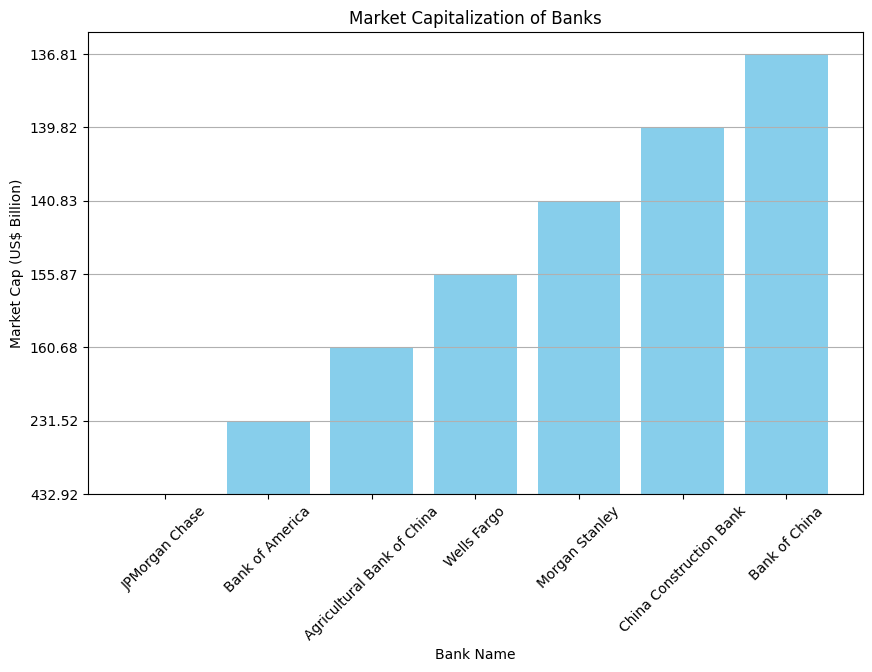

In [135]:
import matplotlib.pyplot as plt

log_message('Starting data visualizing')
# Bar Chart for Market Capitalization
plt.figure(figsize=(10, 6))
plt.bar(banks_df['Bank name'], banks_df['Market cap(US$ billion)'], color='skyblue')
plt.xlabel('Bank Name')
plt.ylabel('Market Cap (US$ Billion)')
plt.title('Market Capitalization of Banks')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

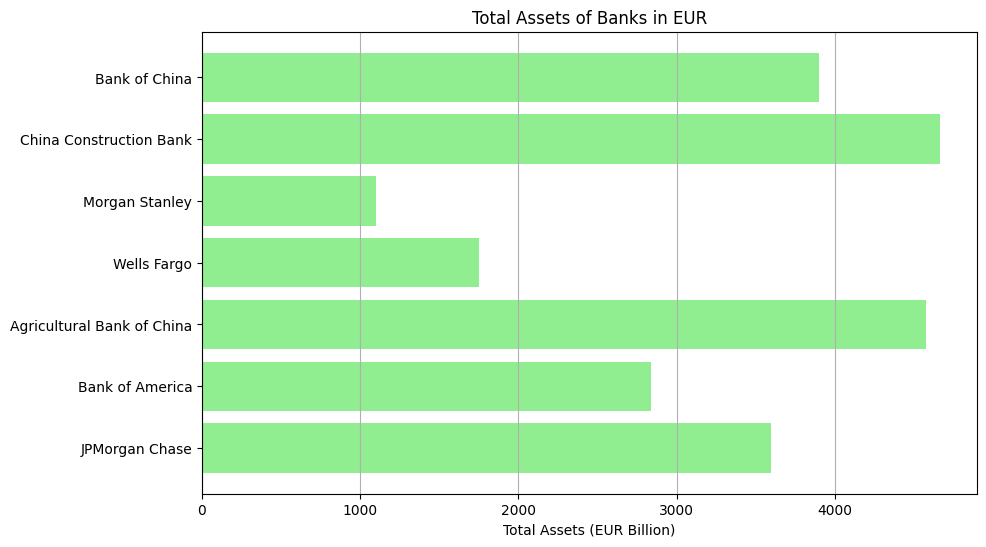

In [136]:
# Bar Chart for Total Assets in EUR
plt.figure(figsize=(10, 6))
plt.barh(banks_df['Bank name'], banks_df['Total assets(2022)(EUR billion)'], color='lightgreen')
plt.xlabel('Total Assets (EUR Billion)')
plt.title('Total Assets of Banks in EUR')
plt.grid(axis='x')
plt.show()

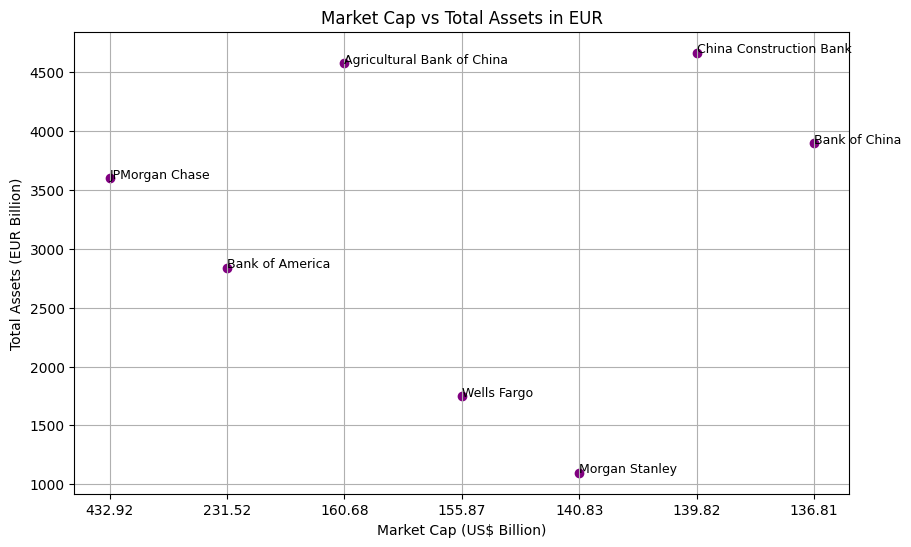

In [137]:
# Scatter Plot for Market Cap vs Total Assets in EUR
plt.figure(figsize=(10, 6))
plt.scatter(banks_df['Market cap(US$ billion)'], banks_df['Total assets(2022)(EUR billion)'], color='purple')
plt.title('Market Cap vs Total Assets in EUR')
plt.xlabel('Market Cap (US$ Billion)')
plt.ylabel('Total Assets (EUR Billion)')
for i, txt in enumerate(banks_df['Bank name']):
    plt.annotate(txt, (banks_df['Market cap(US$ billion)'].iloc[i], banks_df['Total assets(2022)(EUR billion)'].iloc[i]), fontsize=9)
plt.grid()
plt.show()

## Loading to .csv

In [139]:
def save_to_csv(df, filename):
    log_message(f'Saving data to {filename}')
    df.to_csv(filename, index=False)
    log_message('Data saved to CSV')

# Save to CSV
save_to_csv(banks_df, 'transformed_banks_data.csv')


## Loading to Database

In [140]:
import sqlite3

def load_to_db(df, db_name):
    log_message('Loading data into SQLite database')
    conn = sqlite3.connect(db_name)
    df.to_sql('banks', conn, if_exists='replace', index=False)
    conn.close()
    log_message('Data loaded into SQLite database')

# Load to database
load_to_db(banks_df, 'banks.db')


## Function to Run Queries on Database

In [141]:
def run_query(query, db_name='banks.db'):
    log_message(f'Running query: {query}')
    conn = sqlite3.connect(db_name)
    result = pd.read_sql_query(query, conn)
    conn.close()
    log_message('Query executed')
    return result

# Queries
query = 'SELECT * FROM banks'
result_df = run_query(query)

print("\n\nQuery Results: ")
print(result_df)

query = 'SELECT * FROM banks WHERE "Bank name" = "JPMorgan Chase"'
result_df = run_query(query)

print("\n\nQuery Results: ")
print(result_df)




Query Results: 
  Rank                   Bank name Market cap(US$ billion)  \
0    1              JPMorgan Chase                  432.92   
1    2             Bank of America                  231.52   
2    4  Agricultural Bank of China                  160.68   
3    6                 Wells Fargo                  155.87   
4    8              Morgan Stanley                  140.83   
5    9     China Construction Bank                  139.82   
6   10               Bank of China                  136.81   

   Total assets(2022)(US$ billion)  Total assets(2022)(EUR billion)  
0                          3868.24                        3597.4632  
1                          3051.38                        2837.7834  
2                          4919.03                        4574.6979  
3                          1881.02                        1749.3486  
4                          1180.23                        1097.6139  
5                          5016.81                        4665.63

## Verify Log enteries

In [142]:
def verify_log_entries():
    with open('/content/bank_data.log', 'r') as log_file:
        for line in log_file:
            print(line.strip())

# Verify log entries
verify_log_entries()


2024-07-14 09:58:34,241 - INFO - Starting data extraction from Wikipedia
2024-07-14 09:58:35,363 - INFO - Data extraction completed
2024-07-14 09:59:51,110 - INFO - Starting data transformation
2024-07-14 10:01:08,467 - INFO - Data Transformation Completed
2024-07-14 10:01:26,660 - INFO - Starting data visualizing
2024-07-14 10:01:26,699 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-14 10:01:26,701 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-14 10:03:03,722 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-14 10:0